In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import savetxt
from scipy.ndimage.interpolation import shift

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, AveragePooling1D, SimpleRNN, LSTM


In [3]:
#Loading data from PC- data:full original vector of solar irradiance 
col_list = ["Actual Irr"]
data = pd.read_csv("PDNsolar.csv", usecols=col_list)
data = data.rename(columns={"Actual Irr" : "irradiance" }) #Change Column title
print(data.head())

   irradiance
0        0.00
1        0.00
2        0.00
3        3.76
4       21.72


In [4]:
data = data.values
print("Shape of data is ", data.shape)

Shape of data is  (28548, 1)


In [5]:
sigma = np.std(data)
mu = np.mean(data)
datanorm = (data-mu)/sigma

The shape of datamat is  (366, 78)


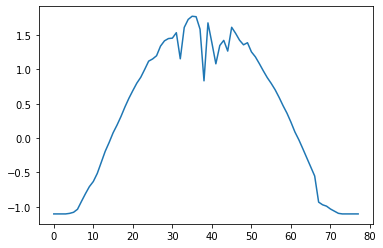

In [6]:
#Random shuffling to matrix across rows
datamat = data.reshape(366,-1)
print("The shape of datamat is ", datamat.shape)
datamat_norm = datanorm.reshape(366,-1)
np.random.shuffle(datamat_norm)
plt.plot(datamat_norm[0])
datanorm = datamat_norm.reshape(-1,1)

In [7]:
#Function to Split into input ouput sets
def split_seq(seq, n_steps):
    X, y = list(), list()
    for i in range(len(seq)):
    
        #Find end of seq
        end_ix = i+n_steps
        #Check if sequence passed
        if end_ix>len(seq)-1:
            break

        #Gather input and ouputs
        seq_x, seq_y = seq[i:end_ix], seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [44]:
n_steps = 4
trainval = 78*256 + 1

unk,y_recon = split_seq(datanorm, n_steps)
y_recon = y_recon[trainval :]

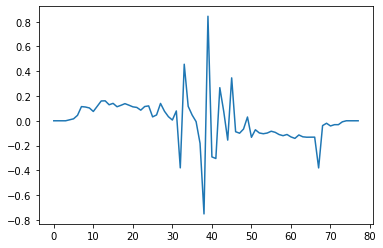

In [45]:
data_diff = datanorm-np.roll(datanorm,1)
plt.plot(data_diff[0:78])

In [46]:
#Training, Testing data split
trainX_diff = data_diff[0:trainval]
testX_diff = data_diff[trainval:]

In [47]:
n_steps = 4
n_features = 1

#Split into inputs, outputs for training data
Xdiff_train, Ydiff_train= split_seq(trainX_diff, n_steps)

Xdiff_train = Xdiff_train.reshape(Xdiff_train.shape[0],Xdiff_train.shape[1], n_features)

#Split into input and outputs for test data
Xdiff_test, Ydiff_test = split_seq(testX_diff, n_steps)

Xdiff_test = Xdiff_test.reshape(Xdiff_test.shape[0], Xdiff_test.shape[1], n_features)

In [48]:
#Define Model
model = tf.keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 2, 64)             256       
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


In [49]:
#Fit model to difference transformed model
hist = model.fit(Xdiff_train, Ydiff_train, epochs=20, batch_size=32, validation_split=0.15, verbose=1, shuffle=False)

Train on 16970 samples, validate on 2995 samples
Epoch 1/20
16970/16970 [==============================] - 3s 168us/sample - loss: 0.1469 - val_loss: 0.1303
Epoch 2/20
16970/16970 [==============================] - 2s 124us/sample - loss: 0.1427 - val_loss: 0.1296
Epoch 3/20
16970/16970 [==============================] - 2s 125us/sample - loss: 0.1419 - val_loss: 0.1296
Epoch 4/20
16970/16970 [==============================] - 2s 124us/sample - loss: 0.1414 - val_loss: 0.1296
Epoch 5/20
16970/16970 [==============================] - 2s 122us/sample - loss: 0.1411 - val_loss: 0.1296
Epoch 6/20
16970/16970 [==============================] - 2s 123us/sample - loss: 0.1408 - val_loss: 0.1297
Epoch 7/20
16970/16970 [==============================] - 2s 123us/sample - loss: 0.1406 - val_loss: 0.1297
Epoch 8/20
16970/16970 [==============================] - 2s 123us/sample - loss: 0.1403 - val_loss: 0.1295
Epoch 9/20
16970/16970 [==============================] - 2s 123us/sample - loss: 0.140

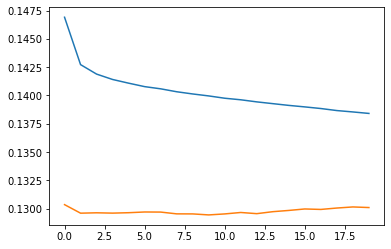

In [50]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='Cross validation')

In [51]:
#Predicting difference transformed data using NN model
yhat_difftest = model.predict(Xdiff_test, verbose=0)

In [52]:
ypred = (yhat_difftest + y_recon)*sigma +mu
yact = (Ydiff_test + y_recon)*sigma +mu

In [53]:
RMSE = np.sqrt(sum((ypred-yact)**2)/len(ypred))
print(f"RMSE is {RMSE}", )

RMSE is [116.19555149]
